In [ ]:
#PCA+keras

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

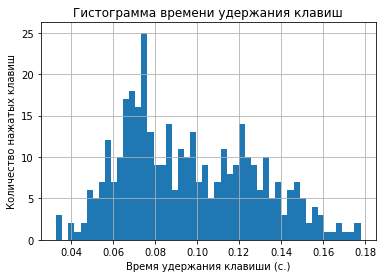

In [261]:
import matplotlib.pyplot as plt

data = pd.read_csv('server/keystroke/userdata/processed_data/Alexander_processed_data.csv')

#fig, ax = plt.subplots(2, 2, figsize=(16,12))

# ax[0, 0].hist(data.HD, 50)
# ax[0, 0].set_xlabel('Время удержания клавиши (с.)')
# ax[0, 0].set_ylabel('Количество нажатых клавиш')
# ax[0, 0].set_title('Гистограмма времени удержания клавиш')
# ax[0, 0].grid(True)

plt.hist(data.HD, 50)
plt.xlabel('Время удержания клавиши (с.)')
plt.ylabel('Количество нажатых клавиш')
plt.title('Гистограмма времени удержания клавиш')
plt.grid(True)
plt.show()


# ax[0, 1].hist(data.PPD, 20)
# ax[0, 1].set_xlabel('Время между нажатиями клавиш (с.)')
# ax[0, 1].set_ylabel('Количество нажатых клавиш')
# ax[0, 1].set_title('Гистограмма времени между нажатиями клавиш')
# ax[0, 1].grid(True)

# ax[1, 0].hist(data.RPD, 20)
# ax[1, 0].set_xlabel('Время перескока между клавишами (с.)')
# ax[1, 0].set_ylabel('Количество нажатых клавиш')
# ax[1, 0].set_title('Гистограмма времени перескока между клавишами')
# ax[1, 0].grid(True)

# ax[1, 1].hist(data.RRD, 20)
# ax[1, 1].set_xlabel('Время между отжатиями клавиш (с.)')
# ax[1, 1].set_ylabel('Количество нажатых клавиш')
# ax[1, 1].set_title('Гистограмма времени между отжатиями клавиш')
# ax[1, 1].grid(True)

In [126]:
print(data.head().time[1])
print(data.head().time[0])
print(data.head().time[1]-data.head().time[0])

IndexError: invalid index to scalar variable.

In [7]:
len(data.sample(frac=1).reset_index(drop=True))

2981

In [10]:
import glob
data = pd.DataFrame(columns=['keycode','HD','PPD','RPD', 'RRD', 'user'])
for file in glob.glob("keystroke/userdata/processed_data/*_processed_data.csv"):
    print('[+]:', file)
    tmp = pd.read_csv(file)
    data = pd.concat([data, tmp], ignore_index=True)

data.to_csv('keystroke/userdata/data.csv', index=False) 

[+]: keystroke/userdata/processed_data\Alexander_processed_data.csv
[+]: keystroke/userdata/processed_data\Alex_processed_data.csv
[+]: keystroke/userdata/processed_data\Artem_processed_data.csv
[+]: keystroke/userdata/processed_data\DDD_processed_data.csv
[+]: keystroke/userdata/processed_data\Imya_processed_data.csv
[+]: keystroke/userdata/processed_data\nevova_processed_data.csv
[+]: keystroke/userdata/processed_data\Nikita_processed_data.csv
[+]: keystroke/userdata/processed_data\Sasha_processed_data.csv


In [4]:
test_data=pd.read_csv('server/keystroke/Nikita_test_logs.csv')
df = pd.DataFrame(columns=['keycode','HD','PPD','RPD', 'RRD', 'user'])

user = 'Nikita'
event_len = len(test_data)

for i in range(event_len-3):
    if str(test_data.iloc[i].event) == 'Down':
        finalData = {}
        cur_key_press_time = test_data.iloc[i].time
        cur_key_release_time =  test_data[(test_data.keycode==test_data.iloc[i].keycode)&(test_data.event=='Up')&(test_data.time>test_data.iloc[i].time)].iloc[0].time
        next_key_press_time = test_data[(test_data.event=='Down')&(test_data.time>test_data.iloc[i].time)].iloc[0].time
        next_key_keycode = test_data[(test_data.event=='Down')&(test_data.time>test_data.iloc[i].time)].iloc[0].keycode
        next_key_release_time =  test_data[(test_data.keycode==next_key_keycode)&(test_data.event=='Up')&(test_data.time>next_key_press_time)].iloc[0].time
        finalData['keycode'] = test_data.iloc[i].keycode
        finalData['HD'] = cur_key_release_time-cur_key_press_time
        finalData['PPD'] = next_key_press_time-cur_key_press_time
        finalData['RPD'] = next_key_press_time-cur_key_release_time
        finalData['RRD'] = next_key_release_time-cur_key_release_time
        df = df.append(finalData,ignore_index=True)

df.keycode = df.keycode.apply(int).apply(str) 

In [72]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
import numpy as np



nu = np.arange(0.01, 1, 0.01)
gamma = np.arange(0.01, 1, 0.0025)
max = 0
for n in nu:
    for g in gamma:
        dif_len_rate = 0
        i = 0
        for l in range(40, 60, 3):
            n_scaler = preprocessing.Normalizer()
            data = pd.read_csv('server/keystroke/userdata/processed_data/Nikita_processed_data.csv')[:l]
            col_names = ['HD', 'PPD', 'RPD', 'RRD']
            data_s = n_scaler.fit_transform(data[col_names])
            data_s = pd.DataFrame(data_s, columns = col_names)
            data_s['keycode']=data.keycode.astype('str')
            clf = OneClassSVM(nu=n, kernel="rbf", gamma=g)
            #clf = SGDOneClassSVM(nu=0.5)
            clf.fit(data_s)

            Alex_data = pd.read_csv('server/keystroke/userdata/processed_data/Alex_processed_data.csv')[:20]
            Alex_data_s = n_scaler.transform(Alex_data[col_names])
            Alex_data_s = pd.DataFrame(Alex_data_s, columns = col_names)
            Alex_data_s['keycode']=Alex_data.keycode.astype('str')
            _, Alex_count =np.unique(clf.predict(Alex_data_s), return_counts=True)
            #print(f'Probability of valid user (Alex_1): {Alex_count[1]/20}')

            DDD_data = pd.read_csv('server/keystroke/userdata/processed_data/DDD_processed_data.csv')[:20]
            DDD_data_s = n_scaler.transform(DDD_data[col_names])
            DDD_data_s = pd.DataFrame(DDD_data_s, columns = col_names)
            DDD_data_s['keycode']=DDD_data.keycode.astype('str')
            _, DDD_count =np.unique(clf.predict(DDD_data_s), return_counts=True)
            #print(f'Probability of valid user (Dmitry): {DDD_count[1]/20}')

            Sasha_data = pd.read_csv('server/keystroke/userdata/processed_data/Sasha_processed_data.csv')[:20]
            Sasha_data_s = n_scaler.transform(Sasha_data[col_names])
            Sasha_data_s = pd.DataFrame(Sasha_data_s, columns = col_names)
            Sasha_data_s['keycode']=Sasha_data.keycode.astype('str')
            _, Sasha_count = np.unique(clf.predict(Sasha_data_s), return_counts=True)
            #print(f'Probability of valid user (Alex_2): {Sasha_count[1]/20}')

            Artem_data = pd.read_csv('server/keystroke/userdata/processed_data/Artem_processed_data.csv')[:20]
            Artem_data_s = n_scaler.transform(Artem_data[col_names])
            Artem_data_s = pd.DataFrame(Artem_data_s, columns = col_names)
            Artem_data_s['keycode']=Artem_data.keycode.astype('str')
            _, Artem_count = np.unique(clf.predict(Artem_data_s), return_counts=True)
            #print(f'Probability of valid user (Artem): {Artem_count[1]/20}')

            df_s = n_scaler.transform(df[col_names])
            df_s = pd.DataFrame(df_s, columns = col_names)
            df_s['keycode']=df.keycode.astype('str')
            _, test_valid_counts = np.unique(clf.predict(df_s[:20]), return_counts=True)
            #print(f'Probability of valid user (Nikita_test): {test_valid_counts[1]/20}')
            _, test_valid_counts_2 = np.unique(clf.predict(df_s[20:40]), return_counts=True)
            #print(f'Probability of valid user (Nikita_test_2): {test_valid_counts_2[1]/20}')
            try:
                false_rate = (Alex_count[1]+DDD_count[1]+Sasha_count[1]+Artem_count[1])/80
                true_rate = (test_valid_counts[1]+test_valid_counts_2[1])/40
                dif_len_rate+=(true_rate-false_rate)
                i+=1
            except:
                pass
        try:
            mean_rate = dif_len_rate/i
            if mean_rate>max:
                max = mean_rate
                max_n = n
                max_g = n
        except:
            pass           
            # if Alex_count[1]/20<0.5 and DDD_count[1]/20<0.5 and Sasha_count[1]/20<0.5 and Artem_count[1]/20<0.5 and test_valid_counts[1]/20>0.59 and test_valid_counts_2[1]/20>0.59:
            #     print(f'nu = {n}, gamma = {g}')
print(f'nu = {max_n}, gamma = {max_g}, max = {max}')        

nu = 0.33, gamma = 0.33, max = 0.2589285714285714


In [186]:
col_names = ['HD', 'PPD', 'RPD', 'RRD']
df_s = n_scaler.fit_transform(df[col_names])
df_s = pd.DataFrame(df_s, columns = col_names)
df_s['keycode']=df.keycode.astype('str')
print(np.unique(clf.predict(df_s[:25]), return_counts=True))

(array([-1,  1], dtype=int64), array([22,  3], dtype=int64))


In [ ]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
import numpy as np

n_scaler = preprocessing.StandardScaler()
data = pd.read_csv('server/keystroke/userdata/processed_data/Nikita_processed_data.csv')[:55]
col_names = ['HD', 'PPD', 'RPD', 'RRD']
data_s = n_scaler.fit_transform(data[col_names])
data_s = pd.DataFrame(data_s, columns = col_names)
data_s['keycode']=data.keycode.astype('str')
        

nu = np.arange(0.01, 1, 0.005)
gamma = np.arange(0.01, 1, 0.0025)
max = 0
for n in nu:
    for g in gamma:
        # dif_len_rate = 0
        # i = 0
        # for l in range(40, 60, 3):
        clf = OneClassSVM(nu=n, kernel="rbf", gamma=g)
        #clf = SGDOneClassSVM(nu=0.5)
        clf.fit(data_s)

        Alex_data = pd.read_csv('server/keystroke/userdata/processed_data/Alex_processed_data.csv')[:20]
        Alex_data_s = n_scaler.transform(Alex_data[col_names])
        Alex_data_s = pd.DataFrame(Alex_data_s, columns = col_names)
        Alex_data_s['keycode']=Alex_data.keycode.astype('str')
        _, Alex_count =np.unique(clf.predict(Alex_data_s), return_counts=True)
        #print(f'Probability of valid user (Alex_1): {Alex_count[1]/20}')

        DDD_data = pd.read_csv('server/keystroke/userdata/processed_data/DDD_processed_data.csv')[:20]
        DDD_data_s = n_scaler.transform(DDD_data[col_names])
        DDD_data_s = pd.DataFrame(DDD_data_s, columns = col_names)
        DDD_data_s['keycode']=DDD_data.keycode.astype('str')
        _, DDD_count =np.unique(clf.predict(DDD_data_s), return_counts=True)
        #print(f'Probability of valid user (Dmitry): {DDD_count[1]/20}')

        Sasha_data = pd.read_csv('server/keystroke/userdata/processed_data/Sasha_processed_data.csv')[:20]
        Sasha_data_s = n_scaler.transform(Sasha_data[col_names])
        Sasha_data_s = pd.DataFrame(Sasha_data_s, columns = col_names)
        Sasha_data_s['keycode']=Sasha_data.keycode.astype('str')
        _, Sasha_count = np.unique(clf.predict(Sasha_data_s), return_counts=True)
        #print(f'Probability of valid user (Alex_2): {Sasha_count[1]/20}')

        Artem_data = pd.read_csv('server/keystroke/userdata/processed_data/Artem_processed_data.csv')[:20]
        Artem_data_s = n_scaler.transform(Artem_data[col_names])
        Artem_data_s = pd.DataFrame(Artem_data_s, columns = col_names)
        Artem_data_s['keycode']=Artem_data.keycode.astype('str')
        _, Artem_count = np.unique(clf.predict(Artem_data_s), return_counts=True)
        #print(f'Probability of valid user (Artem): {Artem_count[1]/20}')

        df_s = n_scaler.transform(df[col_names])
        df_s = pd.DataFrame(df_s, columns = col_names)
        df_s['keycode']=df.keycode.astype('str')
        _, test_valid_counts = np.unique(clf.predict(df_s[:20]), return_counts=True)
        #print(f'Probability of valid user (Nikita_test): {test_valid_counts[1]/20}')
        _, test_valid_counts_2 = np.unique(clf.predict(df_s[20:40]), return_counts=True)
        #print(f'Probability of valid user (Nikita_test_2): {test_valid_counts_2[1]/20}')
        try:
            false_rate = (Alex_count[1]+DDD_count[1]+Sasha_count[1]+Artem_count[1])/80
            true_rate = (test_valid_counts[1]+test_valid_counts_2[1])/40
            dif_len_rate=(true_rate-false_rate)
            if dif_len_rate>max:
                max = dif_len_rate
                max_n = n
                max_g = g
        except:
            pass           
        # if Alex_count[1]/20<0.5 and DDD_count[1]/20<0.5 and Sasha_count[1]/20<0.5 and Artem_count[1]/20<0.5 and test_valid_counts[1]/20>0.59 and test_valid_counts_2[1]/20>0.59:
        #     print(f'nu = {n}, gamma = {g}')
print(f'nu = {max_n}, gamma = {max_g}, max = {max}') 

In [280]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
import numpy as np


n_scaler = preprocessing.Normalizer()
data = pd.read_csv('server/keystroke/userdata/processed_data/Nikita_processed_data.csv')[:200]
col_names = ['HD', 'PPD', 'RPD', 'RRD']
data_s = n_scaler.fit_transform(data[col_names])
data_s = pd.DataFrame(data_s, columns = col_names)
data_s['keycode']=data.keycode.astype('str')
    

nu = np.arange(0.01, 1, 0.0025)
gamma = np.arange(0.01, 5, 0.05)
max = 0
for n in nu:
    for g in gamma:
        # dif_len_rate = 0
        # i = 0
        # for l in range(40, 60, 3):
        clf = OneClassSVM(nu=n, kernel="rbf", gamma=g)
        #clf = SGDOneClassSVM(nu=0.5)
        clf.fit(data_s)

        Alex_data = pd.read_csv('server/keystroke/userdata/processed_data/Alex_processed_data.csv')[:50]
        Alex_data_s = n_scaler.transform(Alex_data[col_names])
        Alex_data_s = pd.DataFrame(Alex_data_s, columns = col_names)
        Alex_data_s['keycode']=Alex_data.keycode.values.astype('str')
        _, Alex_count =np.unique(clf.predict(Alex_data_s), return_counts=True)
        #print(f'Probability of valid user (Alex_1): {Alex_count[1]/20}')

        DDD_data = pd.read_csv('server/keystroke/userdata/processed_data/DDD_processed_data.csv')[:50]
        DDD_data_s = n_scaler.transform(DDD_data[col_names])
        DDD_data_s = pd.DataFrame(DDD_data_s, columns = col_names)
        DDD_data_s['keycode']=DDD_data.keycode.values.astype('str')
        _, DDD_count =np.unique(clf.predict(DDD_data_s), return_counts=True)
        #print(f'Probability of valid user (Dmitry): {DDD_count[1]/20}')

        Sasha_data = pd.read_csv('server/keystroke/userdata/processed_data/Sasha_processed_data.csv')[:50]
        Sasha_data_s = n_scaler.transform(Sasha_data[col_names])
        Sasha_data_s = pd.DataFrame(Sasha_data_s, columns = col_names)
        Sasha_data_s['keycode']=Sasha_data.keycode.values.astype('str')
        _, Sasha_count = np.unique(clf.predict(Sasha_data_s), return_counts=True)
        #print(f'Probability of valid user (Alex_2): {Sasha_count[1]/20}')

        Artem_data = pd.read_csv('server/keystroke/userdata/processed_data/Artem_processed_data.csv')[:50]
        Artem_data_s = n_scaler.transform(Artem_data[col_names])
        Artem_data_s = pd.DataFrame(Artem_data_s, columns = col_names)
        Artem_data_s['keycode']=Artem_data.keycode.values.astype('str')
        _, Artem_count = np.unique(clf.predict(Artem_data_s), return_counts=True)
        #print(f'Probability of valid user (Artem): {Artem_count[1]/20}')

        df_s = n_scaler.transform(df[col_names])
        df_s = pd.DataFrame(df_s, columns = col_names)
        df_s['keycode']=df.keycode.astype('str')
        _, test_valid_counts = np.unique(clf.predict(df_s[25:75]), return_counts=True)
        #print(f'Probability of valid user (Nikita_test): {test_valid_counts[1]/20}')
        _, test_valid_counts_2 = np.unique(clf.predict(df_s[75:125]), return_counts=True)
        #print(f'Probability of valid user (Nikita_test_2): {test_valid_counts_2[1]/20}')
        try:
            false_rate = (Alex_count[1]+DDD_count[1]+Sasha_count[1]+Artem_count[1])/200
            true_rate = (test_valid_counts[1]+test_valid_counts_2[1])/100
            dif_len_rate=(true_rate-false_rate)
            if dif_len_rate>max:
                max_i = i
                max = dif_len_rate
                max_n = n
                max_g = g
        except:
            pass           
    # if Alex_count[1]/20<0.5 and DDD_count[1]/20<0.5 and Sasha_count[1]/20<0.5 and Artem_count[1]/20<0.5 and test_valid_counts[1]/20>0.59 and test_valid_counts_2[1]/20>0.59:
    #     print(f'nu = {n}, gamma = {g}')
print(f'nu = {max_n}, gamma = {max_g}, max = {max}') 

nu = 0.6000000000000001, gamma = 2.61, max = 0.135


In [ ]:
# nu = 0.355, gamma = 0.037500000000000006, max = 0.3125
# nu = 0.5299999999999999, gamma = 0.037500000000000006, max = 0.4 - Normilizer
# nu=0.56, kernel="rbf", gamma=0.035 
# nu=0.04, kernel="rbf", gamma=0.0275 - 50
# nu=0.53, kernel="rbf", gamma=0.0375 - 50
# nu = 0.6100000000000001, gamma = 2.735, max = 0.135 - 200, 50

In [8]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
import numpy as np

#n_scaler = preprocessing.StandardScaler()
n_scaler = preprocessing.Normalizer()
data = pd.read_csv('server/keystroke/userdata/processed_data/Nikita_processed_data.csv')[:200]
col_names = ['HD', 'PPD', 'RPD', 'RRD']
data_s = n_scaler.fit_transform(data[col_names])
data_s = pd.DataFrame(data_s, columns = col_names)
data_s['keycode']=data.keycode.values.astype('str')


clf = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.05)
clf.fit(data_s)

Alex_data = pd.read_csv('server/keystroke/userdata/processed_data/Alex_processed_data.csv')[:50]
Alex_data_s = n_scaler.transform(Alex_data[col_names])
Alex_data_s = pd.DataFrame(Alex_data_s, columns = col_names)
Alex_data_s['keycode']=Alex_data.keycode.values.astype('str')
_, Alex_count =np.unique(clf.predict(Alex_data_s), return_counts=True)
print(f'Вероятность для нелегитимного пользователя (user_1): {Alex_count[1]/50}')

DDD_data = pd.read_csv('server/keystroke/userdata/processed_data/DDD_processed_data.csv')[:50]
DDD_data_s = n_scaler.transform(DDD_data[col_names])
DDD_data_s = pd.DataFrame(DDD_data_s, columns = col_names)
DDD_data_s['keycode']=DDD_data.keycode.values.astype('str')
_, DDD_count =np.unique(clf.predict(DDD_data_s), return_counts=True)
print(f'Вероятность для нелегитимного пользователя (user_2): {DDD_count[1]/50}')

Sasha_data = pd.read_csv('server/keystroke/userdata/processed_data/Sasha_processed_data.csv')[:50]
Sasha_data_s = n_scaler.transform(Sasha_data[col_names])
Sasha_data_s = pd.DataFrame(Sasha_data_s, columns = col_names)
Sasha_data_s['keycode']=Sasha_data.keycode.values.astype('str')
_, Sasha_count = np.unique(clf.predict(Sasha_data_s), return_counts=True)
print(f'Вероятность для нелегитимного пользователя (user_3): {Sasha_count[1]/50}')

Artem_data = pd.read_csv('server/keystroke/userdata/processed_data/Artem_processed_data.csv')[:50]
Artem_data_s = n_scaler.transform(Artem_data[col_names])
Artem_data_s = pd.DataFrame(Artem_data_s, columns = col_names)
Artem_data_s['keycode']=Artem_data.keycode.values.astype('str')
_, Artem_count = np.unique(clf.predict(Artem_data_s), return_counts=True)
print(f'Вероятность для нелегитимного пользователя (user_4): {Artem_count[1]/50}')

df_s = n_scaler.transform(df[col_names])
df_s = pd.DataFrame(df_s, columns = col_names)
df_s['keycode']=df.keycode.values.astype('str')
_, test_valid_counts = np.unique(clf.predict(df_s[:100]), return_counts=True)
print(f'Вероятность для легитимного пользователя (Nikita_test): {test_valid_counts[1]/100}')
_, test_valid_counts_2 = np.unique(clf.predict(df_s[50:150]), return_counts=True)
#print(test_valid_counts_2)
print(f'Вероятность для легитимного пользователя (Nikita_test_2): {test_valid_counts_2[1]/100}')  

Вероятность для нелегитимного пользователя (user_1): 0.8
Вероятность для нелегитимного пользователя (user_2): 0.9
Вероятность для нелегитимного пользователя (user_3): 0.9
Вероятность для нелегитимного пользователя (user_4): 0.98
Вероятность для легитимного пользователя (Nikita_test): 0.9
Вероятность для легитимного пользователя (Nikita_test_2): 0.88


In [208]:
Alex_data = pd.read_csv('server/keystroke/userdata/processed_data/Alex_processed_data.csv')[20:40]

In [247]:
print(f'nu = 0.04, gamma = 0.0275, max_difference = 0.3875')

nu = 0.04, gamma = 0.0275, max_difference = 0.3875


In [219]:
n_scaler = preprocessing.Normalizer()
col_names = ['HD', 'PPD', 'RPD', 'RRD']
Alex_data_s = n_scaler.transform(Alex_data[col_names])
Alex_data_s = pd.DataFrame(Alex_data_s, columns = col_names)
Alex_data_s['keycode'] = Alex_data.keycode.values

In [220]:

Alex_data_s

,HD,PPD,RPD,RRD,keycode
0,0.272348,0.613612,0.341264,0.657911,90
1,0.043371,0.587032,0.543662,0.598284,32
2,0.319863,0.645414,0.325551,0.612490,68
3,0.245874,0.644405,0.398530,0.604535,83
4,0.161800,0.603344,0.441544,0.644078,67
5,0.457788,0.634850,0.177062,0.596695,73
6,0.471750,0.600769,0.129018,0.632363,84
7,0.450394,0.648320,0.197926,0.581077,85
8,0.301625,0.579015,0.277390,0.704853,74
9,0.587647,0.655543,0.067897,0.469388,32


In [216]:
Alex_data.keycode

20     90
21     32
22     68
23     83
24     67
25     73
26     84
27     85
28     74
29     32
30     71
31     74
32     72
33     90
34     76
35     82
36     70
37    191
38     32
39     70
Name: keycode, dtype: int64